**Deep Learning 2023/24 - Final Project**
===============

Prediction of Stock Prices
---------------

## Team:
- Lukas Weigmann
- Andre Datchev
- Hannes Pohnke

-----------------------------------

Outline
1. Preface/Intro/benchmark
2. Dataset
3. Data preparation
4. model 1
5. model 2 
6. model ...
7. Evaluation
8. Conclusion

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


## *1. Introduction*

## *Acquiring data*

----------------------------------

We will use yfinance to load the price histories of the Stocks we want to have.

/Users/lukasweigmann/miniconda3/envs/FinancialForecasting/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


             Open   High    Low  Close  Adj Close   Volume
Date                                                      
2020-08-07  18.00  18.49  15.25  15.40      15.40  2677900
2020-08-10  15.65  18.00  15.00  17.15      17.15   459800
2020-08-11  17.00  17.93  15.25  15.60      15.60   213400
2020-08-12  15.38  15.96  14.90  15.20      15.20   389800
2020-08-13  14.81  15.39  14.67  15.10      15.10   114000 
 (879, 6) 

            Adj Close
Date                 
2020-08-07      15.40
2020-08-10      17.15
2020-08-11      15.60
2020-08-12      15.20
2020-08-13      15.10


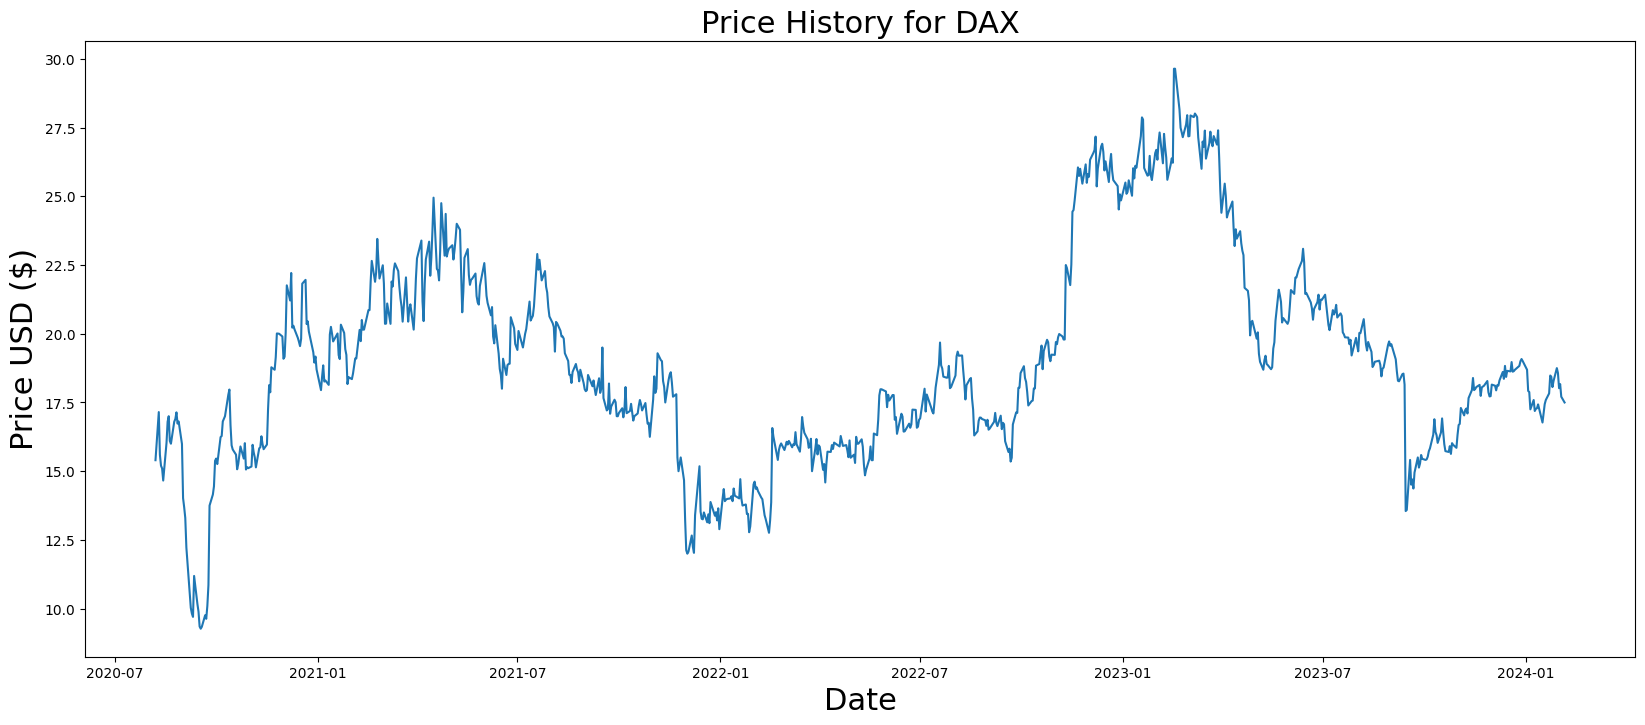

In [13]:
yf.pdr_override()
pd.set_option('display.max_rows', None)

#timeframe we want to load the data from in years
timeframe = 5

#setting end and start date 
end = datetime.now()
    #end = datetime(end .year - 1, end.month, end.day)
start = datetime(end.year - timeframe, end.month, end.day)

#how the downloaded dataframe looks
dax = pdr.get_data_yahoo("IBeX", start, end)
print(dax.head(), "\n", dax.shape, "\n")

#extracting the price history
dax_history = dax.filter(["Adj Close"])
print(dax_history.head())

#visulazing
def plot_history(history, index):
    plt.figure(figsize=(20,8))
    plt.title('Price History for ' + index, fontsize=22)
    plt.plot(history)
    plt.xlabel('Date', fontsize=22)
    plt.ylabel('Price USD ($)', fontsize=22)

    plt.show()
    
plot_history(dax_history, "DAX")


In [14]:
# stock_data = PyTickerSymbols()
# 
# # Tickers for current dax companies
# # ! We'll only use current DAX companies (the size composition of the index changes through time)
# 
# dax_overview = stock_data.get_stocks_by_index('DAX') # this includes additional data like industry, number of employees but not super useful ig
# dax_tickers = [entry['symbol'] for entry in dax_overview]
# dax_tickers = [f"{ticker}.F" for ticker in dax_tickers] # F for Frankfurt tickers
# print(dax_tickers)
# 
# if 'DPW.F' in dax_tickers: 
#     dax_tickers[dax_tickers.index('DPW.F')] = 'DPWA.F' # seemingly PyTickerSymbols() doesnt know of this name change yet 


In [15]:
#loading data of all DAX stock
"""
def load_histories(indices):
    stock_histories = []
    for index in indices :
        stock = pdr.get_data_yahoo(index, start, end)
        adj_close_history = stock['Adj Close']
        stock_histories.append(adj_close_history)
        
    return stock_histories

stocks = ['ADS.F', 'ALV.F', 'BAS.F', 'BAYN.F', 'BEI.F', 'BMW.F', 'CON.F', 
          '1COV.F', 'DBK.F', 'DB1.F', 'DPWA.F', 'DTE.F', 'EOAN.F', 'FME.F', 
          'FRE.F', 'HEI.F', 'HEN3.F', 'IFX.F', 'LIN.F', 'MRK.F', 'MUV2.F', 
          'RWE.F', 'SAP.F', 'SIE.F', 'VOW3.F', 'VNA.F', 'AIR.F', 'BNR.F', 
          'HNR1.F', 'MTX.F', 'PUM.F', 'QIA.F', 'SRT3.F', 'SHL.F', 'SY1.F', 
          'ZAL.F', 'ENR.F', 'PAH3.F', 'DTG.F', 'MBG.F']

dax_histories = load_histories(stocks)
"""

"\ndef load_histories(indices):\n    stock_histories = []\n    for index in indices :\n        stock = pdr.get_data_yahoo(index, start, end)\n        adj_close_history = stock['Adj Close']\n        stock_histories.append(adj_close_history)\n        \n    return stock_histories\n\nstocks = ['ADS.F', 'ALV.F', 'BAS.F', 'BAYN.F', 'BEI.F', 'BMW.F', 'CON.F', \n          '1COV.F', 'DBK.F', 'DB1.F', 'DPWA.F', 'DTE.F', 'EOAN.F', 'FME.F', \n          'FRE.F', 'HEI.F', 'HEN3.F', 'IFX.F', 'LIN.F', 'MRK.F', 'MUV2.F', \n          'RWE.F', 'SAP.F', 'SIE.F', 'VOW3.F', 'VNA.F', 'AIR.F', 'BNR.F', \n          'HNR1.F', 'MTX.F', 'PUM.F', 'QIA.F', 'SRT3.F', 'SHL.F', 'SY1.F', \n          'ZAL.F', 'ENR.F', 'PAH3.F', 'DTG.F', 'MBG.F']\n\ndax_histories = load_histories(stocks)\n"

In [16]:
#Filtering 'incomplete' histories
"""
lengths = [len(history) for history in dax_histories]

# Count the occurrences of each length
from collections import Counter
length_counts = Counter(lengths)

# Display the unique lengths and their frequencies
for length, count in length_counts.items():
    print(f"Length {length}: {count} occurrences")
    """

'\nlengths = [len(history) for history in dax_histories]\n\n# Count the occurrences of each length\nfrom collections import Counter\nlength_counts = Counter(lengths)\n\n# Display the unique lengths and their frequencies\nfor length, count in length_counts.items():\n    print(f"Length {length}: {count} occurrences")\n    '

In [17]:
"""
filtered_histories = [history for history in dax_histories if len(history) == 763]

# Convert to NumPy array for model to use
stock_array = np.array(filtered_histories)
"""

'\nfiltered_histories = [history for history in dax_histories if len(history) == 763]\n\n# Convert to NumPy array for model to use\nstock_array = np.array(filtered_histories)\n'

## *3. Data Preparation*

---------------------------------

- normalize
- train test split
- transform
- ...

### 1. Prediction of tomorrows price

In [75]:
#Feature Scaling
dataset = dax_history.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
print(scaled_dataset[:5])

[[0.30093272]
 [0.38684338]
 [0.31075112]
 [0.29111437]
 [0.28620521]]


In [76]:
#lookback window for prediction:
lag = 20

#train test split:
ratio = 0.8

train_data_len = int(np.ceil( len(dataset) * ratio ))

train_data, test_data = scaled_dataset[:train_data_len, :], scaled_dataset[train_data_len - lag:]

#print(train_data[training_data_len - 10:], "\n\n", test_data[:10])
print(len(dataset), "=", len(train_data), "+", len(test_data), "+", lag)

879 = 704 + 195 + 20


In [77]:
# Data transformation: We will create datasamples with a corresponding label from our linear history. 
# Each sample will be 60 consecutive Values and the label y will be the price for the day after.

def create_samples(sequential_data, lag=20):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)):
        x.append(sequential_data[i-lag:i, 0])
        y.append(sequential_data[i, 0])
    return np.array(x), np.array(y)

train_X, train_Y = create_samples(train_data, lag)
#print(train_X.shape)
#print(train_Y.shape)


test_X, test_Y = create_samples(test_data, lag)

train_X

array([[0.30093272, 0.38684338, 0.31075112, ..., 0.23318607, 0.21698573,
        0.19783996],
       [0.38684338, 0.31075112, 0.29111437, ..., 0.21698573, 0.19783996,
        0.14482081],
       [0.31075112, 0.29111437, 0.28620521, ..., 0.19783996, 0.14482081,
        0.03730974],
       ...,
       [0.60333823, 0.586647  , 0.52380956, ..., 0.50024542, 0.5115366 ,
        0.54982815],
       [0.586647  , 0.52380956, 0.54639174, ..., 0.5115366 , 0.54982815,
        0.60530194],
       [0.52380956, 0.54639174, 0.54982815, ..., 0.54982815, 0.60530194,
        0.59548354]])

### 2. Classification in 5 categories

Since a prediction for the next day is not really useful we want to do a classicification in 5 categories. For this we compare price of the current date with the price at a future point in time and categorize the increase/decrease. The idea is to get a category for a small increase, a big increase, stagnation, small decrease and big decrease. This way we want to obtain a more abstract tendency or trend based on past data.
We consider this a more useful and robust approach since the stock price is also very dependent on daily events and in order to obtain more abstract trends the market needs a wider time frame.

(879, 1)


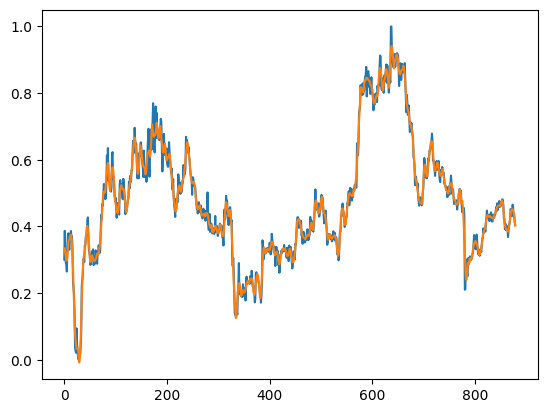

In [102]:
# Smoothing the curve with moving average
from scipy.signal import savgol_filter

plt.plot(scaled_dataset)

print(scaled_dataset.shape)

smoothed_dataset = savgol_filter(scaled_dataset[:,0], window_length=15, polyorder=5).reshape(-1,1)

plt.plot(smoothed_dataset)


In [103]:
def getTrainingAndTestData(lag=60):
    ratio = 0.8

    train_data_len = int(np.ceil( len(dataset) * ratio ))

    train_data = smoothed_dataset[:train_data_len, :]
    test_data = smoothed_dataset[train_data_len - lag:]
    
    return train_data, test_data 


In [104]:
# We will create samples that use the past <lag> days and are labelled with the category label according to percental change
# in the next <predictionPeriod>

def create_samples(sequential_data, category_boundaries=[-10, -3, 3, 10], shift=3, lag=60, prediction_period=7):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)-prediction_period, shift):
        x.append(sequential_data[i-lag:i, 0])
        percental_change = (sequential_data[i+prediction_period]/sequential_data[i]-1)*100
        for index, boundary in enumerate(category_boundaries):
            if percental_change <= boundary:
                y.append(index)
                break
        if percental_change > category_boundaries[3]:
            y.append(4)
    return np.array(x), np.array(y)


In [105]:
train_data, test_data = getTrainingAndTestData()

train_X, train_Y = create_samples(train_data)

test_X, test_Y = create_samples(test_data)

train_X.shape, train_Y.shape

((213, 60), (213,))

# Our Model



In [78]:
#initializing model
model = Sequential()
model.add(LSTM(4, input_shape= (lag, 1)))
#model.add(LSTM(128, return_sequences=True, input_shape= (lag, 1)))
#model.add(LSTM(64, return_sequences=True))
#model.add(LSTM(32, return_sequences=False))
#model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

2024-02-06 12:22:43.988612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-06 12:22:43.989401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-06 12:22:43.989843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [79]:
#training
model.fit(train_X, train_Y, batch_size=10, epochs=50)

Epoch 1/50


2024-02-06 12:22:44.118704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-06 12:22:44.119429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-06 12:22:44.120000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

69/69 [==============================] - 1s 3ms/step - loss: 0.2997
Epoch 2/50
69/69 [==============================] - 0s 3ms/step - loss: 0.0570
Epoch 3/50
69/69 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 4/50
69/69 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 5/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 7/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 8/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 9/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 10/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 11/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 12/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 13/50
69/69 [==============================] - 0s 2ms/

In [80]:
#making predictions
predictions = model.predict(test_X)
print(scaled_dataset[train_data_len:train_data_len + 5])
print(predictions[:5])
predictions = scaler.inverse_transform(predictions)

print(dataset[train_data_len:train_data_len + 5])
print(predictions[:5])

6/6 [==============================] - 0s 1ms/step
[[0.54688267]
 [0.55473735]
 [0.54442812]
 [0.55031908]
 [0.57584684]]
[[0.5612198 ]
 [0.5573484 ]
 [0.5574309 ]
 [0.55283993]
 [0.5509149 ]]
[[20.40999985]
 [20.56999969]
 [20.36000061]
 [20.47999954]
 [21.        ]]
[[20.70205 ]
 [20.623188]
 [20.624868]
 [20.53135 ]
 [20.492138]]


2024-02-06 12:22:53.101281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-06 12:22:53.101948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-06 12:22:53.102344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<class 'pandas.core.frame.DataFrame'>


/var/folders/nq/txffqhjx7fj21328vd8t3g_80000gn/T/ipykernel_54247/2179748128.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = preds


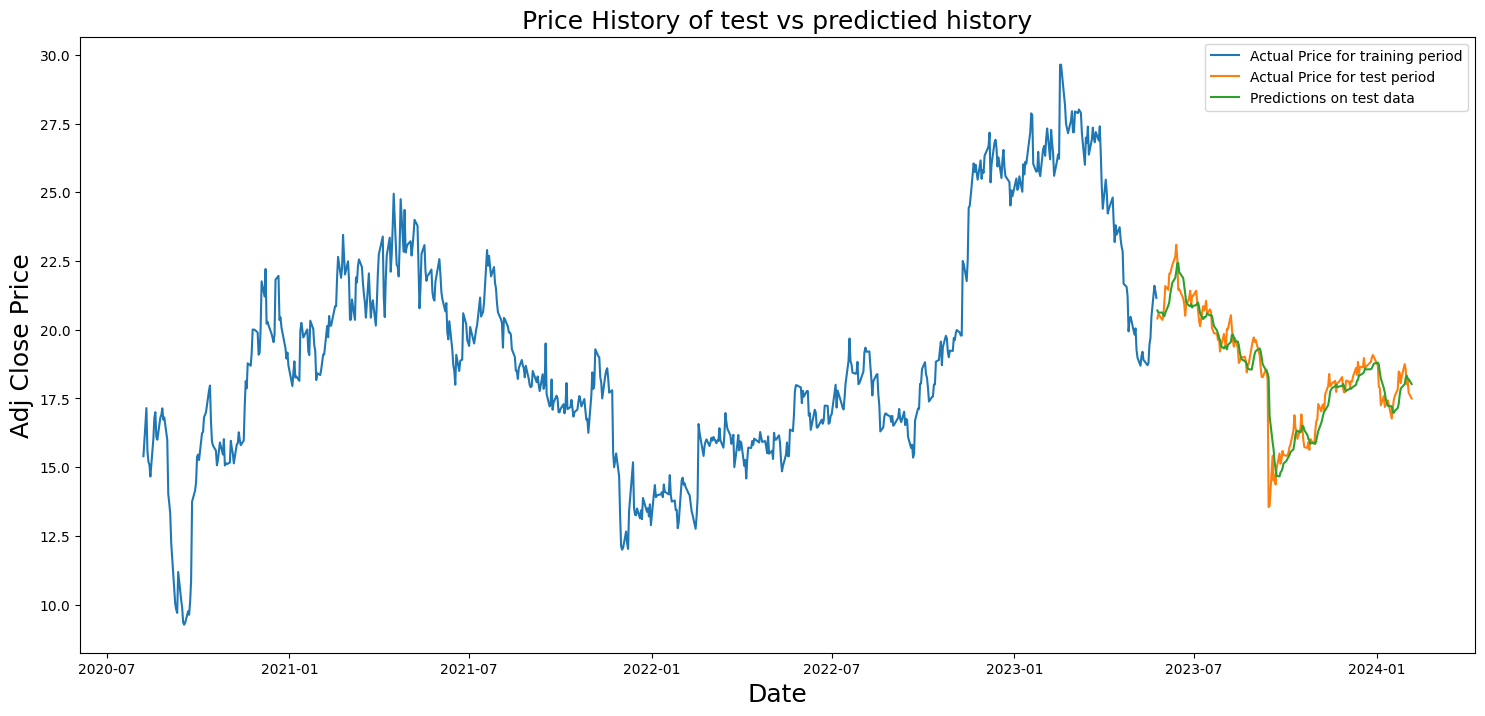

MSE: 325.7148426439425


In [81]:
mse_model1 = mean_squared_error(predictions, test_Y)
rmse_model1 = np.sqrt(mse_model1)

#visualize Results
def plot_results(stock, train, test, preds):
    test['predictions'] = preds
    
    plt.figure(figsize=(18,8))
    plt.plot(train)
    plt.plot(test)
    plt.title(f"Price History of {stock} vs predictied history", fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price', fontsize=18)
    plt.legend(['Actual Price for training period', 'Actual Price for test period', 'Predictions on test data'])
    
    plt.show()
    

print(type(dax_history))
train_history = dax_history[:train_data_len]
test_history = dax_history[train_data_len:]
plot_results("test", train_history, test_history, predictions)

print(f"MSE: {mse_model1}")